In [1]:
#Pre-requisites
!nvidia-smi
!pip install gdown
!pip install tensorflow-gpu

#Let’s download the data
#!gdown --id 152sWECukjvLerrVG2NUO8gtMFg83RKCF --output WISDM_ar_latest.tar.gz
#!tar -xvf WISDM_ar_latest.tar.gz
# !gdown https://cdap-fmg.s3.us-east-2.amazonaws.com/WISDM_WATCH_ACCEL.txt
!gdown https://drive.google.com/uc?id=1bol4ADpBa5G7GJ3ilUxbAiRLKUh-qm4g

Sun Oct  4 09:02:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('WISDM_WATCH_ACCEL.txt', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

# removing the 'timestamp' column.
df.pop('timestamp')
df.head() #Outputs the first few lines of Data
#df.shape #Outputs number of rows and collumns

,user_id,activity,x_axis,y_axis,z_axis
0,1600,Walking,7.091625,-0.591667,8.195502
1,1600,Walking,4.972757,-0.158317,6.696732
2,1600,Walking,3.253720,-0.191835,6.107758
3,1600,Walking,2.801216,-0.155922,5.997625
4,1600,Walking,3.770868,-1.051354,7.731027


spliting the data into training and test datasets:

In [4]:
df_train = df[df['user_id'] <= 1640]
df_test = df[df['user_id'] > 1640]

scaling the accelerometer data values:

In [5]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [6]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [7]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [8]:
# The model is defined as a Sequential Keras model, for simplicity.
# We will define the model as having a single LSTM hidden layer. 
# This is followed by a dropout layer intended to reduce overfitting of the model to the training data. 
# Finally, a dense fully connected layer is used to interpret the features extracted by the LSTM hidden layer, 
# before a final output layer is used to make predictions.


model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]],
          name="ltsm_1"
      ),name="bidirectional_1"
    )
)
model.add(keras.layers.Dropout(rate=0.25,name="dropout_1"))
model.add(keras.layers.Dense(units=128, activation='relu',name="dense_1"))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax',name="output"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


In [9]:
# one epoch = one forward pass and one backward pass of all the training examples
# batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
# number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_split=0.1,
    shuffle=False,
)

Epoch 1/300
307/307 [==============================] - 7s 24ms/step - loss: 1.3328 - acc: 0.4062 - val_loss: 1.6934 - val_acc: 0.4188
Epoch 2/300
307/307 [==============================] - 7s 21ms/step - loss: 1.2115 - acc: 0.4553 - val_loss: 1.4080 - val_acc: 0.4661
Epoch 3/300
307/307 [==============================] - 7s 21ms/step - loss: 1.0457 - acc: 0.5099 - val_loss: 1.8052 - val_acc: 0.5092
Epoch 4/300
307/307 [==============================] - 7s 21ms/step - loss: 1.0854 - acc: 0.5103 - val_loss: 1.1951 - val_acc: 0.5821
Epoch 5/300
307/307 [==============================] - 7s 21ms/step - loss: 1.1100 - acc: 0.4754 - val_loss: 1.2917 - val_acc: 0.4390
Epoch 6/300
307/307 [==============================] - 7s 21ms/step - loss: 1.1773 - acc: 0.4615 - val_loss: 1.2227 - val_acc: 0.4578
Epoch 7/300
307/307 [==============================] - 6s 21ms/step - loss: 1.1194 - acc: 0.4645 - val_loss: 1.1827 - val_acc: 0.4202
Epoch 8/300
307/307 [==============================] - 6s 21ms

In [10]:
# See how well can it predict the test data, second number is accuracy percentage
model.evaluate(X_test, y_test)

142/142 [==============================] - 1s 8ms/step - loss: 0.4381 - acc: 0.9155


[0.43814757466316223, 0.9155241250991821]

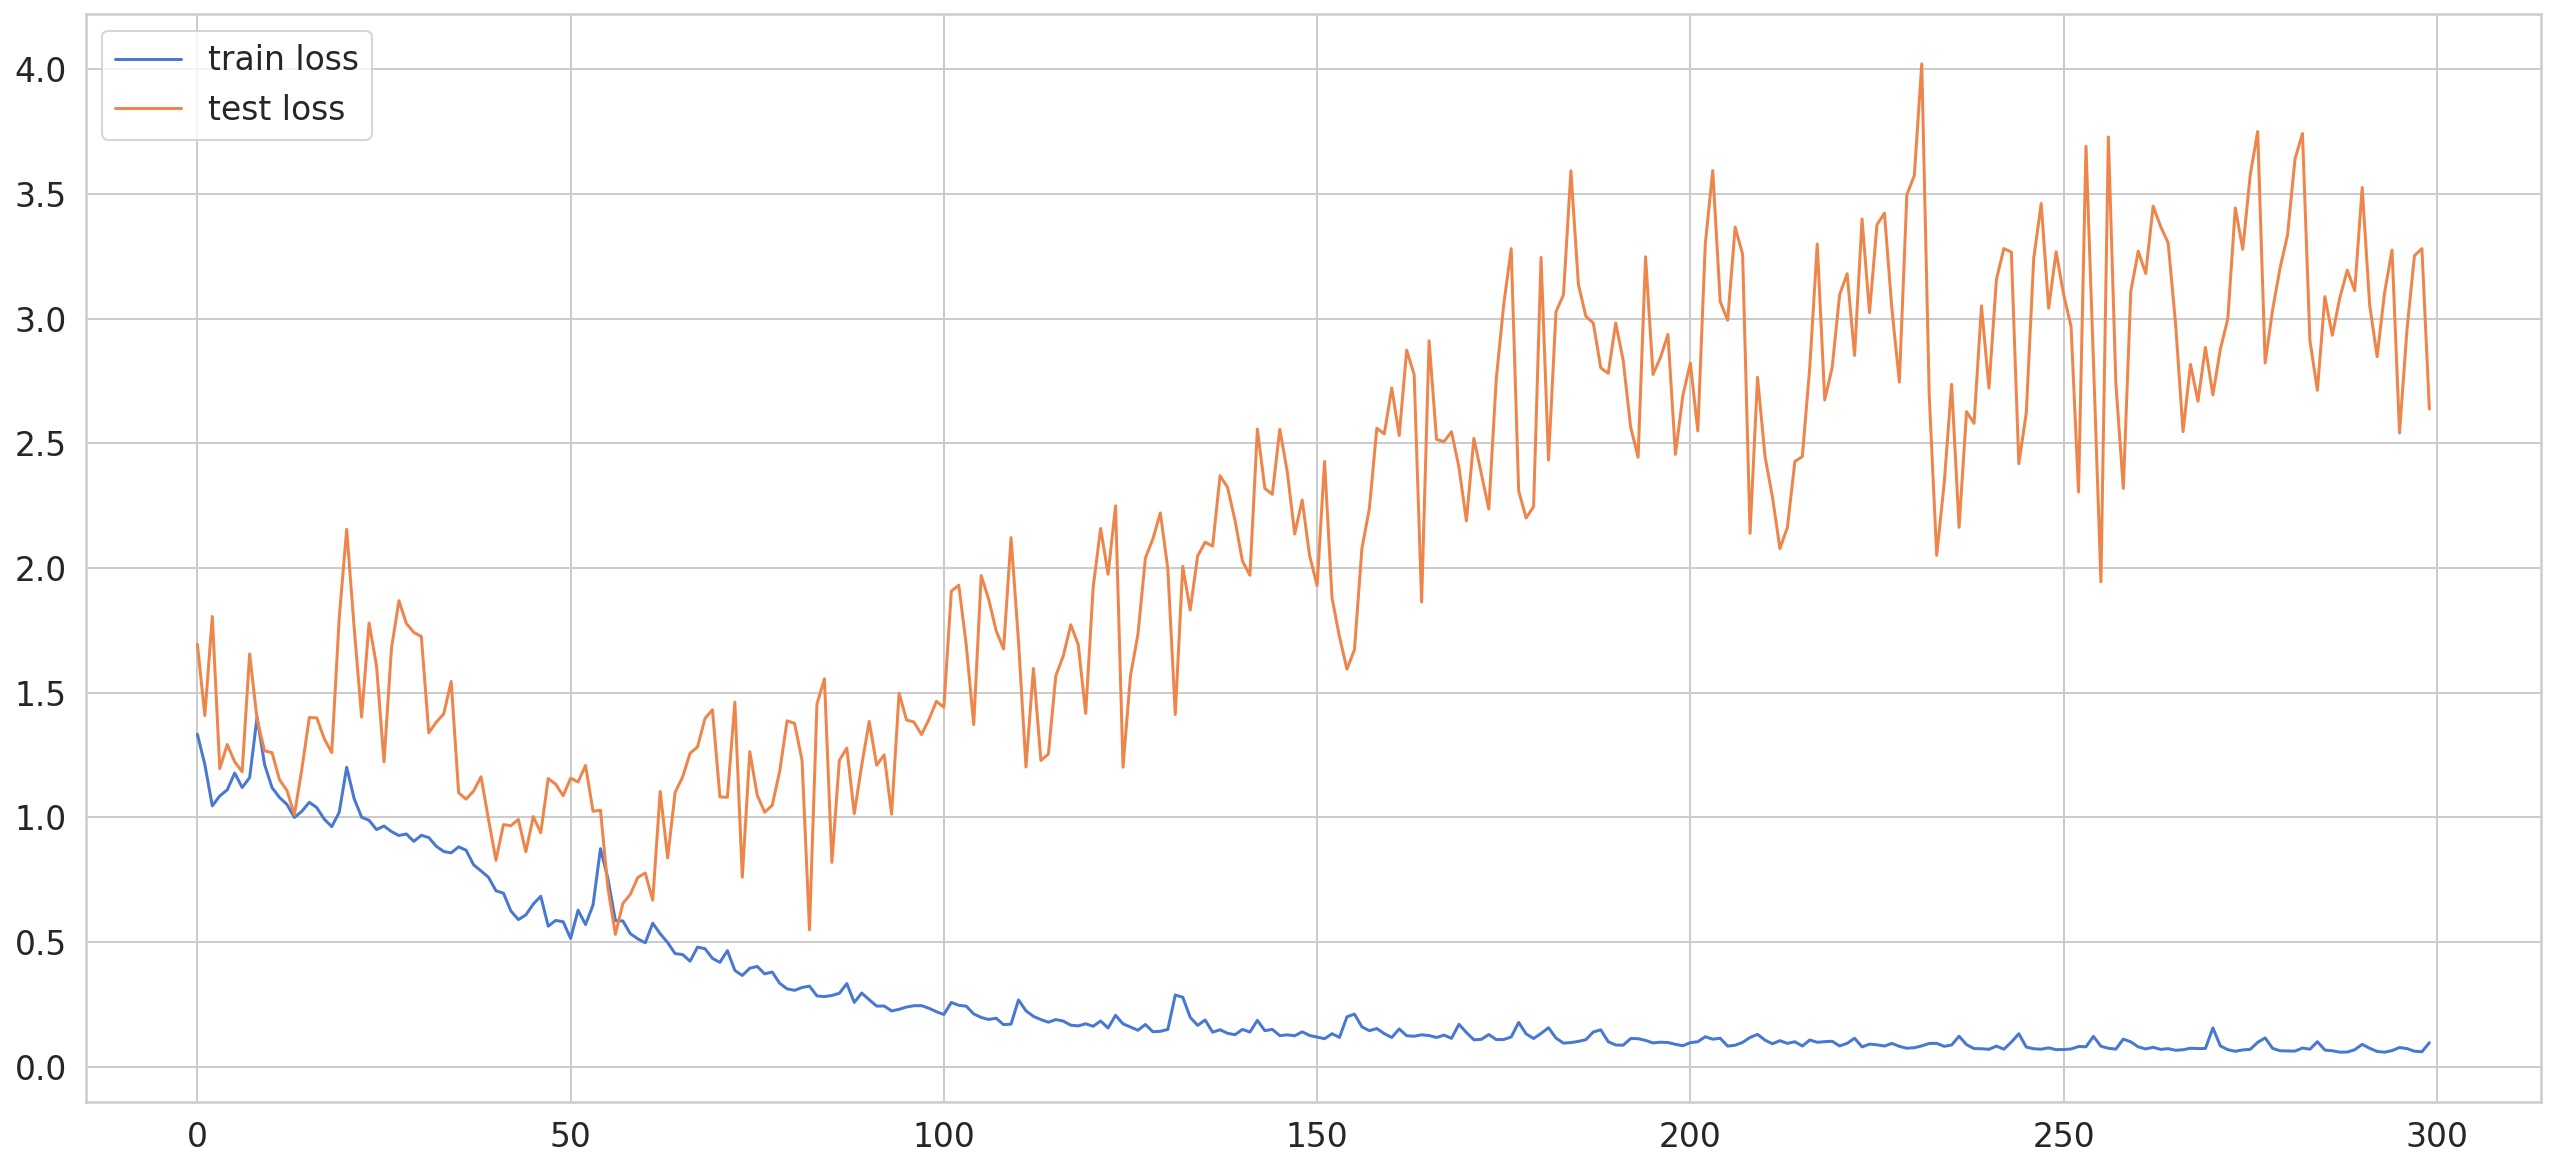

In [11]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

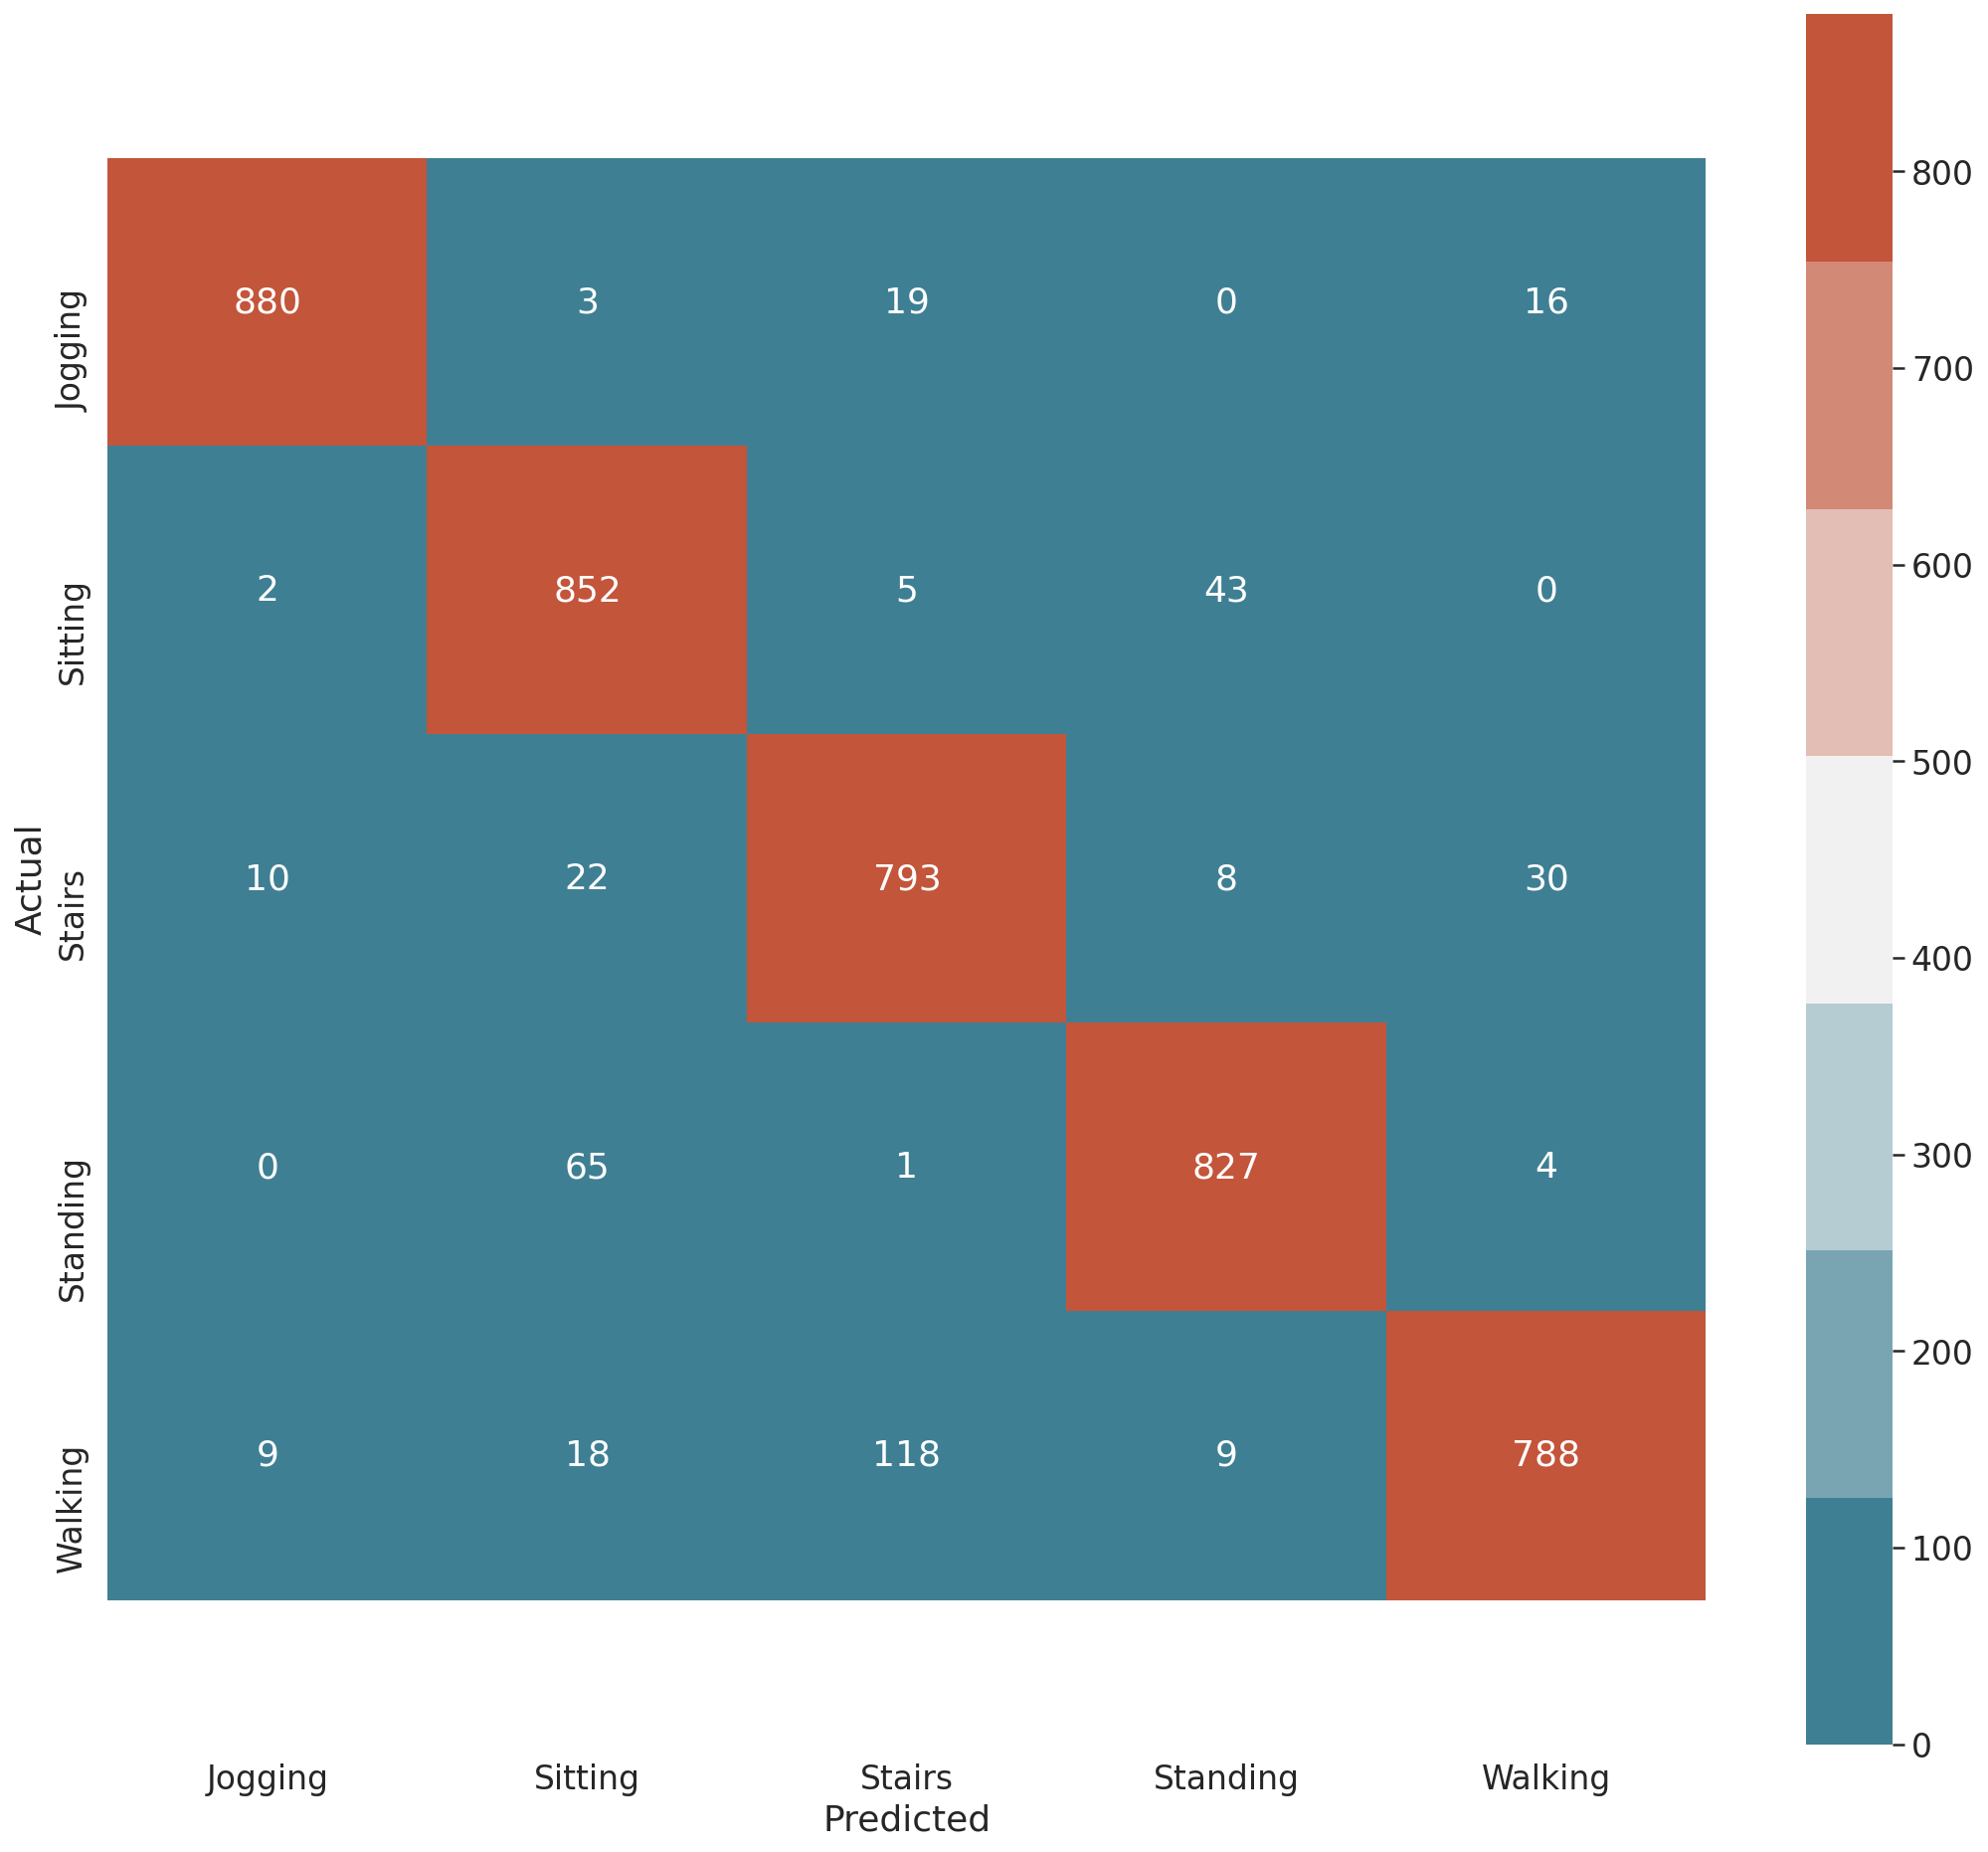

In [12]:
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

In [13]:
# Exporting the model

model.save("lifestyle_model.h5")

#reloading saved model
new_model = tf.keras.models.load_model('lifestyle_model.h5')
new_model.summary()

print("\nmain model result ///////////////////////////////////////////////////////")
model.evaluate(X_test, y_test) # main model result

print("\nsaved and loaded model result ///////////////////////////////////////////////////////")
new_model.evaluate(X_test, y_test) # saved and loaded model result


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 256)               135168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 5)                 645       
Total params: 168,709
Trainable params: 168,709
Non-trainable params: 0
_________________________________________________________________

main model result ///////////////////////////////////////////////////////
142/142 [==============================] - 1s 8ms/step - loss: 0.4381 - acc: 0.9155

saved and loaded model result ///////////////////////////////////////////////////////
14

[0.43814757466316223, 0.9155241250991821]